# **1. Import Libraries**



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization,GlobalAveragePooling2D, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Add,UpSampling2D, Concatenate, Input,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import VGG16, ResNet50
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.colors as colors

# **2. Loading Data**

In [ ]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

# Unzip the downloaded dataset
!unzip -q "satellite-images-of-water-bodies.zip" -d "satellite-images-of-water-bodies"

Dataset URL: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies
License(s): CC-BY-NC-SA-4.0
 98% 241M/247M [00:02<00:00, 121MB/s]
100% 247M/247M [00:02<00:00, 105MB/s]


In [ ]:
path = '/content/drive/MyDrive/ACV/Project/test'
#path = 'satellite-images-of-water-bodies/Water Bodies Dataset'

# **3. Data Preprocessing**

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (256, 256), batch_size = 6000, shuffle = False)

Found 24 files belonging to 2 classes.


In [ ]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(24, 256, 256, 3) (24,)


In [ ]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(12, 256, 256, 3) (12, 256, 256, 3)


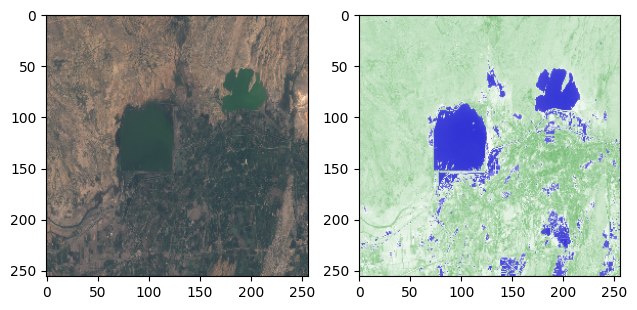

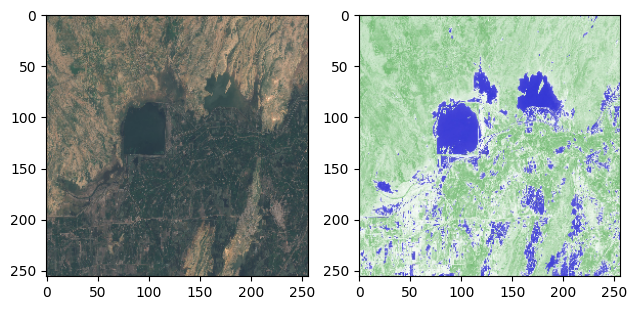

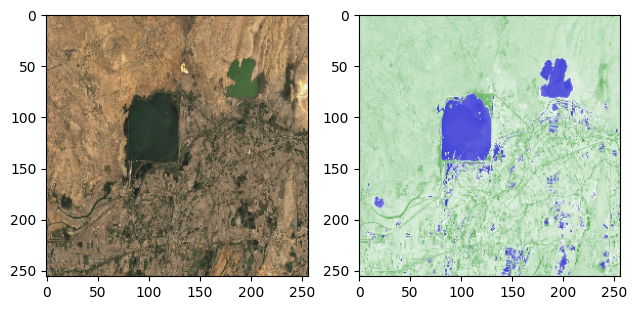

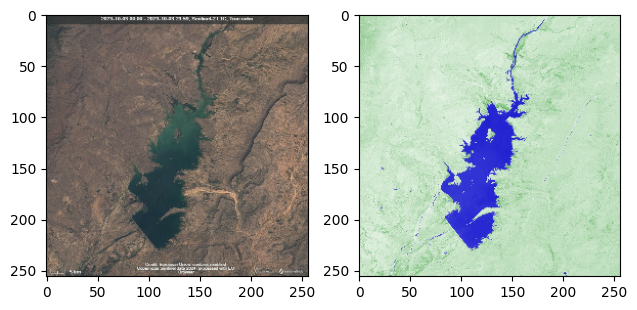

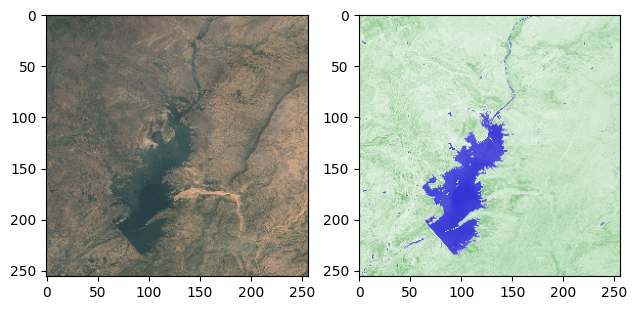

In [ ]:
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i])

    plt.tight_layout()
    plt.show()

**3.1 Threshold Example**

In [ ]:
# Specific indices for examples
indices = [1237, 100, 1000, 589, 89]

In [ ]:
# Predefined parameters
mask_k = np.ones((5, 5), dtype="uint8")
lower_blue = np.array([90, 50, 70], dtype=np.uint8)
upper_blue = np.array([128, 255, 255], dtype=np.uint8)

In [ ]:
def plot_images(image, mask, index):
    figure, axis = plt.subplots(1, 5, figsize=(15, 10))

    Example_Water = image
    Example_Mask = mask

    # Thresholds
    _, Threshold_Water_50 = cv2.threshold(Example_Water, 50, 255, cv2.THRESH_BINARY_INV)
    _, Threshold_Water_150 = cv2.threshold(Example_Water, 150, 255, cv2.THRESH_BINARY_INV)

    # Bitwise mask
    HSV_Water = cv2.cvtColor(Example_Water, cv2.COLOR_RGB2HSV)
    Inrange_Mask = cv2.inRange(HSV_Water, lower_blue, upper_blue)
    Dilate_Img = cv2.dilate(Inrange_Mask, mask_k)
    Bitwise_Img = cv2.bitwise_and(Example_Water, Example_Water, mask=Dilate_Img)

    # Plot original image
    axis[0].imshow(Example_Water)
    axis[0].set_xlabel(f'Shape: {Example_Water.shape}')
    axis[0].set_ylabel(f'Size: {Example_Water.size}')
    axis[0].set_title(f"WATER IDX {index}")

    # Plot mask
    axis[1].imshow(Example_Mask)
    axis[1].set_xlabel(f'Shape: {Example_Mask.shape}')
    axis[1].set_ylabel(f'Size: {Example_Mask.size}')
    axis[1].set_title(f"MASK IDX {index}")

    # Plot threshold with 10
    axis[2].imshow(Threshold_Water_50)
    axis[2].set_xlabel(f'Shape: {Threshold_Water_50.shape}')
    axis[2].set_ylabel(f'Size: {Threshold_Water_50.size}')
    axis[2].set_title("THRESHOLD 10")

    # Plot threshold with 150
    axis[3].imshow(Threshold_Water_150)
    axis[3].set_xlabel(f'Shape: {Threshold_Water_150.shape}')
    axis[3].set_ylabel(f'Size: {Threshold_Water_150.size}')
    axis[3].set_title("THRESHOLD 150")

    # Plot bitwise image
    axis[4].imshow(Bitwise_Img)
    axis[4].set_xlabel(f'Shape: {Bitwise_Img.shape}')
    axis[4].set_ylabel(f'Size: {Bitwise_Img.size}')
    axis[4].set_title(f"BITWISE IDX {index}")

    plt.show()

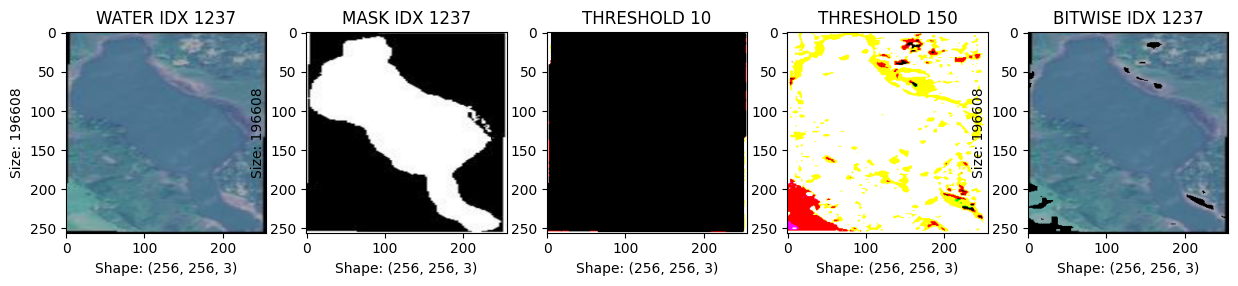

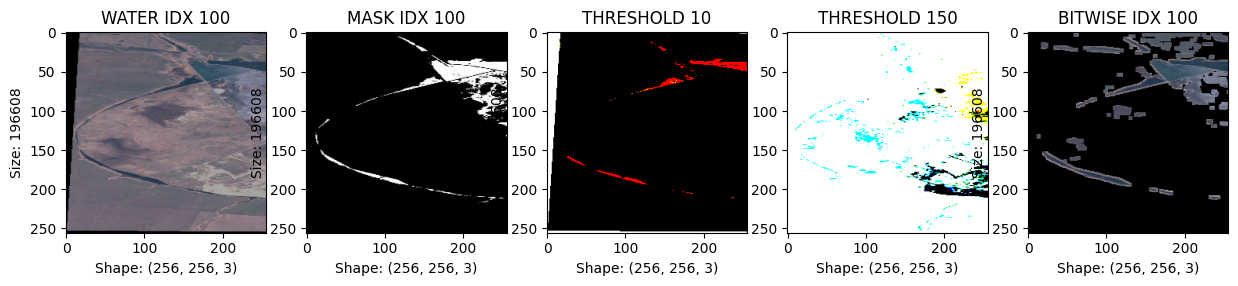

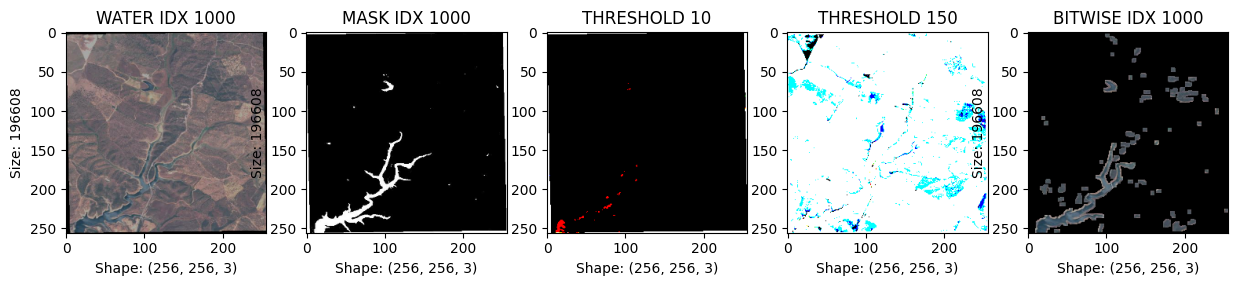

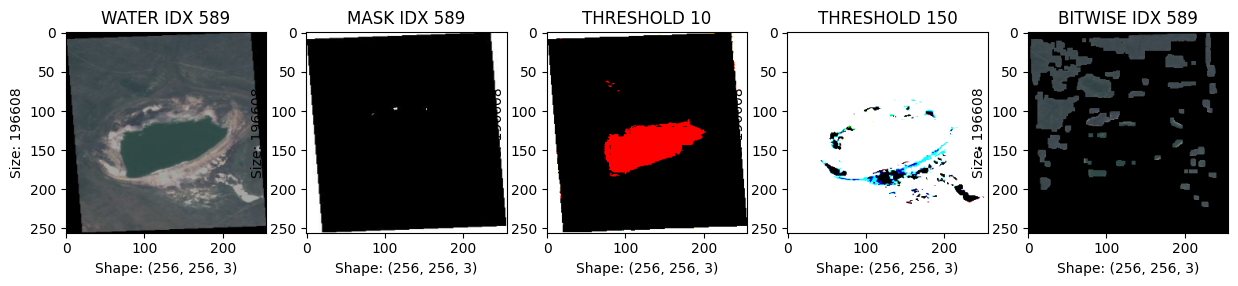

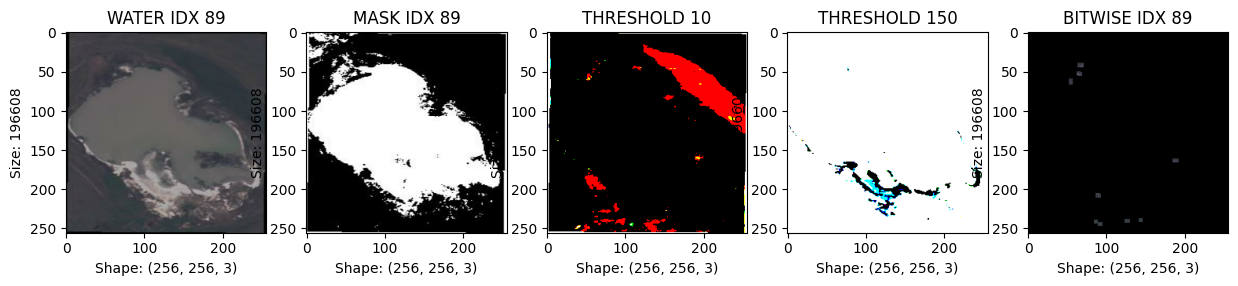

In [ ]:
for idx in indices:
    plot_images(images[idx], masks[idx], idx)

**3.2 Convert to Grayscale**

**Gray Scale**
1. Converting images to grayscale reduces the complexity of the model and the amount of data to process
2. For water body segmentation, the presence of water can often be determined by the intensity of the pixels rather than their color. Grayscale conversion simplifies the problem without significant loss of information

**Using 1 Channel**
1. Using a single channel (grayscale) input reduces the computational load and memory requirements
2. The number of output channels (num_classes) is typically set to 1 for binary segmentation tasks (water vs. non-water)


In [ ]:
X = np.zeros(shape = images.shape[:-1] + (1, ))
y = np.zeros(shape = masks.shape[:-1] + (1, ))

for i in range(X.shape[0]):
    X[i] = tf.image.rgb_to_grayscale(images[i])
    y[i] = tf.image.rgb_to_grayscale(masks[i])

print(X.shape, y.shape)

(2841, 256, 256, 1) (2841, 256, 256, 1)


**3.3 Normalization**

In [ ]:
X = X / 255.0
y = y / 255.0

**3.4 Split Data into train and test**

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 256, 256, 1) (569, 256, 256, 1)


# **4. Define Encoder and Decoder**

In [ ]:
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(inputs)
    x = tf.keras.layers.Activation('elu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('elu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x)
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    skip_features = tf.image.resize(skip_features, size = (x.shape[1], x.shape[2]))
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('elu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('elu')(x)
    return x

**Early Stopping**

In [ ]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True)

# **5. U-Net**

In [ ]:
def unet_model(input_shape = (128, 128, 1), num_classes = 1):
    inputs = tf.keras.layers.Input(shape = input_shape)

    s1 = encoder_block(inputs, 50)
    s2 = encoder_block(s1, 100)
    s3 = encoder_block(s2, 150)
    s4 = encoder_block(s3, 200)

    b1 = tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(s4)
    b1 = tf.keras.layers.Activation('elu')(b1)
    b1 = tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(b1)
    b1 = tf.keras.layers.Activation('elu')(b1)

    s5 = decoder_block(b1, s4, 200)
    s6 = decoder_block(s5, s3, 150)
    s7 = decoder_block(s6, s2, 100)
    s8 = decoder_block(s7, s1, 50)

    outputs = tf.keras.layers.Conv2D(filters = num_classes, kernel_size = (1, 1), padding = "same", activation = "sigmoid")(s8)

    model = tf.keras.models.Model(inputs = [inputs], outputs = [outputs], name = 'U-Net')
    return model

In [ ]:
model = unet_model(input_shape = (256, 256, 1), num_classes = 1)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 50)         500       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 50)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 50)         22550     ['activation[0][0]']          
                                                                                              

In [ ]:
model.compile(optimizer = "adam", loss = "BinaryCrossentropy", metrics = "accuracy")

**5.1 Train U-Net Model**

In [ ]:
history = model.fit(X_train, y_train, epochs = 50, validation_split = 0.2, callbacks = [c1])

Epoch 1/50
57/57 [==============================] - 69s 1s/step - loss: 0.4007 - accuracy: 0.7085 - val_loss: 0.3811 - val_accuracy: 0.7122
Epoch 2/50
57/57 [==============================] - 68s 1s/step - loss: 0.3971 - accuracy: 0.7101 - val_loss: 0.3797 - val_accuracy: 0.7105
Epoch 3/50
57/57 [==============================] - 68s 1s/step - loss: 0.3889 - accuracy: 0.7144 - val_loss: 0.3686 - val_accuracy: 0.7187
Epoch 4/50
57/57 [==============================] - 68s 1s/step - loss: 0.3839 - accuracy: 0.7160 - val_loss: 0.3633 - val_accuracy: 0.7213
Epoch 5/50
57/57 [==============================] - 68s 1s/step - loss: 0.3793 - accuracy: 0.7181 - val_loss: 0.3564 - val_accuracy: 0.7230
Epoch 6/50
57/57 [==============================] - 68s 1s/step - loss: 0.3698 - accuracy: 0.7233 - val_loss: 0.3544 - val_accuracy: 0.7247
Epoch 7/50
57/57 [==============================] - 68s 1s/step - loss: 0.3714 - accuracy: 0.7226 - val_loss: 0.3512 - val_accuracy: 0.7226
Epoch 8/50
57/57 [==

# **6. ViT**

In [ ]:
class ViTBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super(ViTBlock, self).__init__()
        self.ln1 = LayerNormalization()
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ln2 = LayerNormalization()
        self.mlp = tf.keras.Sequential([
            Dense(mlp_dim, activation=tf.nn.gelu),
            Dense(embed_dim),
        ])

    def call(self, inputs):
        x = self.ln1(inputs)
        x = self.attn(x, x)
        x = Add()([x, inputs])
        y = self.ln2(x)
        y = self.mlp(y)
        return Add()([y, x])

def create_vit_segmentation_model(input_shape, num_classes, num_layers=8, embed_dim=64, num_heads=8, mlp_dim=128, patch_size=16):
    inputs = tf.keras.layers.Input(shape=input_shape)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_embeddings = Conv2D(filters=embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches_flat = Reshape((num_patches, embed_dim))(patch_embeddings)

    x = patches_flat
    for _ in range(num_layers):
        x = ViTBlock(embed_dim, num_heads, mlp_dim)(x)

    x = Reshape((input_shape[0] // patch_size, input_shape[1] // patch_size, embed_dim))(x)
    x = Conv2DTranspose(filters=num_classes, kernel_size=patch_size, strides=patch_size, padding='same', activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
vit_model = create_vit_segmentation_model(input_shape=(256, 256, 1), num_classes=1)
vit_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        16448     
                                                                 
 reshape (Reshape)           (None, 256, 64)           0         
                                                                 
 vi_t_block (ViTBlock)       (None, 256, 64)           149504    
                                                                 
 vi_t_block_1 (ViTBlock)     (None, 256, 64)           149504    
                                                                 
 vi_t_block_2 (ViTBlock)     (None, 256, 64)           149504    
                                                                 
 vi_t_block_3 (ViTBlock)     (None, 256, 64)           149504

In [ ]:
vit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**6.1 Train ViT Model**

In [ ]:
vit_history = vit_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[c1])

Epoch 1/50
57/57 [==============================] - 10s 181ms/step - loss: 0.3488 - accuracy: 0.7335 - val_loss: 0.4207 - val_accuracy: 0.7041
Epoch 2/50
57/57 [==============================] - 10s 169ms/step - loss: 0.3481 - accuracy: 0.7335 - val_loss: 0.3813 - val_accuracy: 0.7142
Epoch 3/50
57/57 [==============================] - 10s 167ms/step - loss: 0.3420 - accuracy: 0.7369 - val_loss: 0.3940 - val_accuracy: 0.7056
Epoch 4/50
57/57 [==============================] - 9s 166ms/step - loss: 0.3458 - accuracy: 0.7356 - val_loss: 0.3875 - val_accuracy: 0.7138
Epoch 5/50
57/57 [==============================] - 9s 166ms/step - loss: 0.3414 - accuracy: 0.7374 - val_loss: 0.3894 - val_accuracy: 0.7151
Epoch 6/50
57/57 [==============================] - 9s 165ms/step - loss: 0.3345 - accuracy: 0.7400 - val_loss: 0.3854 - val_accuracy: 0.7158
Epoch 7/50
57/57 [==============================] - 9s 164ms/step - loss: 0.3458 - accuracy: 0.7350 - val_loss: 0.4028 - val_accuracy: 0.6987
Epo

# **7. Plot Trainig and Validation History**

In [ ]:
def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

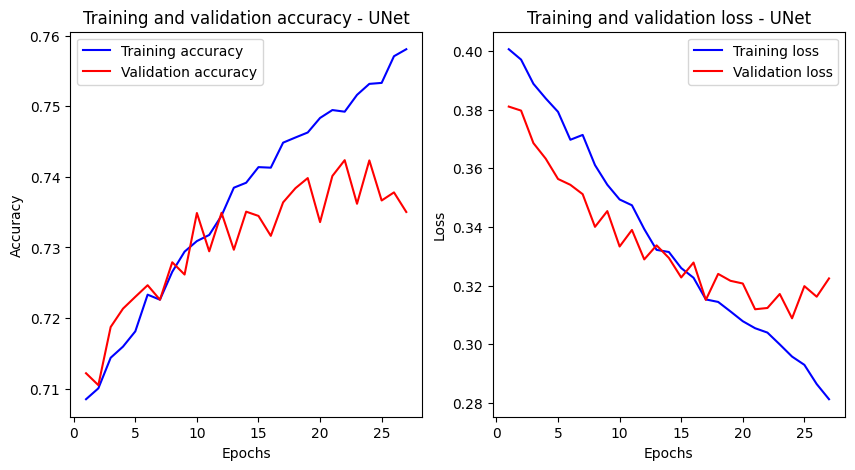

In [ ]:
plot_training_history(history, "UNet")

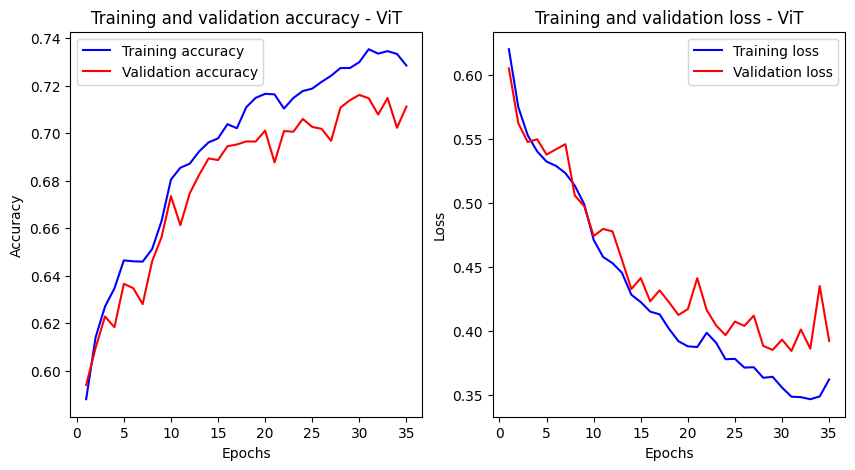

In [ ]:
plot_training_history(vit_history, "ViT")

# **8. Prediction on New Data**

**8.1 Load Data**

In [ ]:
test_path = '/content/drive/MyDrive/ACV/Project/test'

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(directory = test_path, image_size = (256, 256), batch_size = 6000, shuffle = False)

Found 24 files belonging to 2 classes.


In [ ]:
for images, mask in test_data:
    test_X = images.numpy().astype("uint8")
    test_y = mask.numpy().astype("uint8")
    file_names = test_data.file_paths
print(test_X.shape, test_y.shape)

(24, 256, 256, 3) (24,)


In [ ]:
dates = [os.path.basename(file_name).split('-')[-1].split('.')[0].strip() for file_name in file_names]

In [ ]:
test_images = test_X[test_y == 0]
test_masks = test_X[test_y == 1]

print(test_images.shape, test_masks.shape)

(12, 256, 256, 3) (12, 256, 256, 3)


**8.2 Visualize Data**

In [ ]:
for i in range(12):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    plt.title("Date: " + dates[i]) # Print file name
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(test_masks[i])
    plt.title("Date: " + dates[i]) # Print file name
    plt.axis("off")

    plt.tight_layout()
    plt.show()

**8.3 Normalization and Conversion to Grayscale**

In [ ]:
normalize_X = test_images / 255.0
test_X_grayscale = tf.image.rgb_to_grayscale(normalize_X)

**8.4 Preciction from trained ViT model**

In [ ]:
vit_masks = vit_model.predict(test_X_grayscale)

1/1 [==============================] - 1s 1s/step


**8.5 Prediction from U-Net model**

In [ ]:
unet_masks = model.predict(test_X_grayscale)

1/1 [==============================] - 6s 6s/step


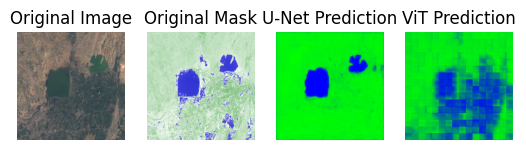

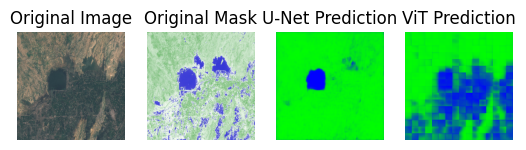

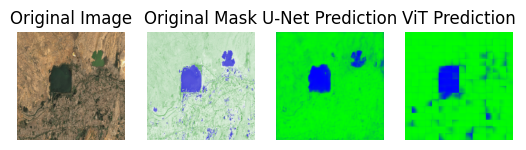

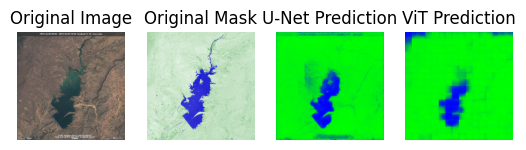

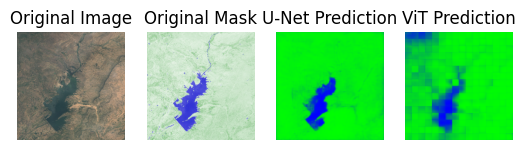

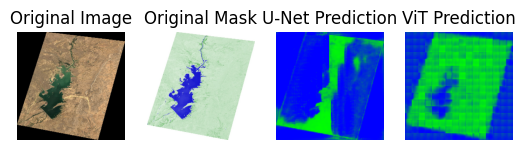

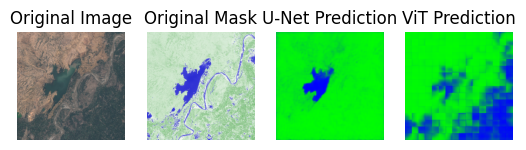

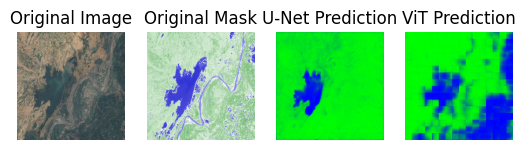

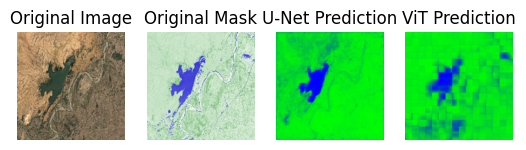

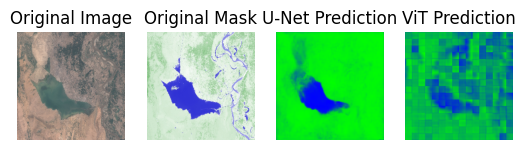

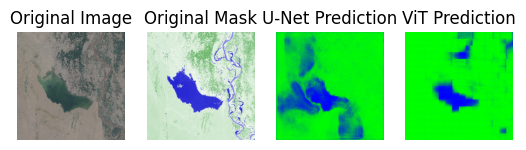

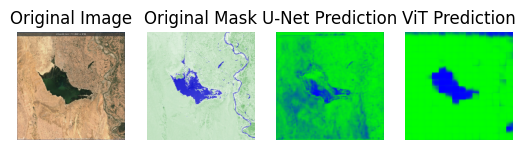

In [ ]:
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", [(0, 1, 0), (0, 0, 1)], N=256)
for i in range(12):
    # Original image
    plt.subplot(1, 4, 1)
    plt.imshow(test_images[i])
    plt.title("Date: " + dates[i]) # Print file name
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(test_masks[i])
    plt.title("Date: " + dates[i]) # Print file name
    plt.title("Original Mask")
    plt.axis("off")

    # U-Net prediction
    plt.subplot(1, 4, 3)
    plt.imshow(unet_masks[i], cmap=cmap)
    plt.title("Date: " + dates[i]) # Print file name
    plt.title("U-Net Prediction")
    plt.axis("off")

    # ViT prediction
    plt.subplot(1, 4, 4)
    plt.imshow(vit_masks[i], cmap=cmap)
    plt.title("Date: " + dates[i]) # Print file name
    plt.title("ViT Prediction")
    plt.axis("off")

    plt.show()